<a href="https://colab.research.google.com/github/kundajelab/fastISM/blob/dev/notebooks/colab/DeepSEA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# fastISM on DeepSEA Beluga

Benchmarking and exploring fastISM on the DeepSEA Beluga model ([Zhou et al 2018](https://www.nature.com/articles/s41588-018-0160-6)), which predicts 2002 chromatin features for a 2000 bp input sequence.

## Installations and Data

In [1]:
# install fastISM
!pip install fastism

  Found existing installation: pydot 1.3.0
    Uninstalling pydot-1.3.0:
      Successfully uninstalled pydot-1.3.0


In [2]:
#for visualizing the per-position importance
!pip install vizsequence 

  Created wheel for vizsequence: filename=vizsequence-0.1.1.0-cp36-none-any.whl size=3269 sha256=f5c7dd7708c4186bbdadb6e2e428969bec77fb97b43315a0eb60a4ddf1f6c62f
  Stored in directory: /root/.cache/pip/wheels/08/eb/de/6b398b439ba39c278e5c341bdeed57d66280910e096496eaef
Successfully built vizsequence


In [3]:
# download trained model
! wget http://mitra.stanford.edu/kundaje/surag/fastISM/deepseabeluga_keras_nopermutelayer.h5 -O deepseabeluga.h5

--2020-09-20 06:25:21--  http://mitra.stanford.edu/kundaje/surag/fastISM/deepseabeluga_keras_nopermutelayer.h5
Resolving mitra.stanford.edu (mitra.stanford.edu)... 171.67.96.243
Connecting to mitra.stanford.edu (mitra.stanford.edu)|171.67.96.243|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 598186116 (570M)
Saving to: ‘deepseabeluga.h5’

deepseabeluga.h5    100%[===================>] 570.47M  48.5MB/s    in 12s     

2020-09-20 06:25:33 (46.9 MB/s) - ‘deepseabeluga.h5’ saved [598186116/598186116]



In [4]:
# download output annotation
! wget https://raw.githubusercontent.com/FunctionLab/ExPecto/20b99d1278678/resources/deepsea_beluga_2002_features.tsv -O outputs.tsv

--2020-09-20 06:25:35--  https://raw.githubusercontent.com/FunctionLab/ExPecto/20b99d1278678/resources/deepsea_beluga_2002_features.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203001 (198K) [text/plain]
Saving to: ‘outputs.tsv’

outputs.tsv         100%[===================>] 198.24K  --.-KB/s    in 0.04s   

2020-09-20 06:25:36 (5.37 MB/s) - ‘outputs.tsv’ saved [203001/203001]



## Init

In [10]:
import fastism
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import vizsequence

# for some seaborn warnings
import warnings; warnings.simplefilter('ignore')

import time

In [6]:
tf.__version__

'2.3.0'

In [7]:
!nvidia-smi

Sun Sep 20 06:25:38 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [9]:
device = 'GPU:0' if tf.config.experimental.list_physical_devices('GPU') else '/device:CPU:0'
device

'GPU:0'

## Load Model

In [17]:
model = tf.keras.models.load_model("deepseabeluga.h5")

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1993, 320)         10560     
_________________________________________________________________
activation_1 (Activation)    (None, 1993, 320)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1986, 320)         819520    
_________________________________________________________________
activation_2 (Activation)    (None, 1986, 320)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1986, 320)         0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 496, 320)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 489, 480)         

In [19]:
model.input.shape

TensorShape([None, 2000, 4])

In [12]:
outputs = pd.read_csv("./outputs.tsv", sep="\t")
outputs

,Unnamed: 0,Cell type,Assay,Treatment,Assay type,Source,Unnamed: 6
0,1,8988T,DNase,NaN,DNase,ENCODE,./wgEncodeAwgDnaseUniform/wgEncodeAwgDnaseDuke...
1,2,AoSMC,DNase,NaN,DNase,ENCODE,./wgEncodeAwgDnaseUniform/wgEncodeAwgDnaseDuke...
2,3,Chorion,DNase,NaN,DNase,ENCODE,./wgEncodeAwgDnaseUniform/wgEncodeAwgDnaseDuke...
3,4,CLL,DNase,NaN,DNase,ENCODE,./wgEncodeAwgDnaseUniform/wgEncodeAwgDnaseDuke...
4,5,Fibrobl,DNase,NaN,DNase,ENCODE,./wgEncodeAwgDnaseUniform/wgEncodeAwgDnaseDuke...
...,...,...,...,...,...,...,...
1997,1998,Osteoblasts,H3K4me2,NaN,Histone,Roadmap Epigenomics,E129-H3K4me2.narrowPeak.gz
1998,1999,Osteoblasts,H3K4me3,NaN,Histone,Roadmap Epigenomics,E129-H3K4me3.narrowPeak.gz
1999,2000,Osteoblasts,H3K79me2,NaN,Histone,Roadmap Epigenomics,E129-H3K79me2.narrowPeak.gz
2000,2001,Osteoblasts,H3K9me3,NaN,Histone,Roadmap Epigenomics,E129-H3K9me3.narrowPeak.gz


## Benchmark

Calculate approximate speedup of fastISM vs a naive implementation.

In [ ]:
def time_ism(ism_model, batch_sizes, seqlen):
    times = []
    per_100 = []
    for b in batch_sizes:
        # using randomly initialized tensors for benchmarking
        x = np.random.random((b,seqlen,4))
        x = tf.constant(x, dtype=ism_model.model.input.dtype)
        
        t = time.time()
        # each position is substituted with 0s for benchmarking
        ism_model(x)
        times.append(time.time()-t)

        per_100.append((times[-1]/b)*100)

        print("BATCH: {}\tTIME: {:.2f}\tPER 100: {:.2f}".format(b, times[-1], (times[-1]/b)*100))
    
    print("BEST PER 100: {:.2f}".format(min(per_100)))

In [20]:
fast_ism_model = fastism.FastISM(model, test_correctness=False)

In [ ]:
# 512 works with 16Gb GPU memory
time_ism(fast_ism_model, [128, 512], 2000)

BATCH: 128	TIME: 42.58	PER 100: 33.26
BATCH: 512	TIME: 85.09	PER 100: 16.62
BEST PER 100: 16.62


In [21]:
naive_ism_model = fastism.NaiveISM(model)

In [ ]:
time_ism(naive_ism_model, [128, 512], 2000)

BATCH: 128	TIME: 142.26	PER 100: 111.14
BATCH: 512	TIME: 513.30	PER 100: 100.25
BEST PER 100: 100.25


Naive ISM takes around 100 seconds per 100 sequence, while fastISM takes around 16.6 seconds. That's a speedup of about 6x!

## Explore

Run fastISM on selected sequences, check correctness and visualize the outputs.

In [22]:
# chr3:138862274-138864275
chr3_enhancer = "CCGGTGATTTTCTGGAGTCTATATCCTTCATCAGATTTTCCAAGGGGTGTCTGTCCCCTCAAAAGAATGATTGTCATTATTTGAAAGACTAGTTCCAGACAGATATTTTATACAAATTTTCCCAGCATTGACATCCCTGAACCAAACTGTTTTTCTTCCCAACATTACTGTTTTCTTCCTTTCTGTCGAGTTTGTTGTTTTGTAATATCAGAATCTCCAGCTCACCTGAGTAAATGGTAACAAGGTGCCACCACCTTTGAATTCTCCCAGAATCCACCCCACCCTCCGTCAGAGCCACTGCCAAGGCACTCTTACTGATTTCTCCCACACTGCTGGCTCATTGCAAGTGGGAAGACAGCATGTGGAGTGGGTGTGCGGCTTATTAAAGTGAGAACTCAGGGTCAGGGCAGAACCAGGAAGAGAGCAGTGAGATATCCTGCTACCTAATCCAATTCTCCTTTTTGTGCATTTAGCACCCTCCCCTCCGCCTGCATAACAATGGAAGGAAAGAGGAAGTGGGAAAAAAGAAAGTCATGTAATTGAGTTAGAAGAGGTAATGACCAAGACCCTGGAGCAGAGGGAAAGCGGGTTACAAAAGGTGGGTTAAAGAAATCACAAGAGTATGAAGAGCTGGGAAATTACTAACAAATATTTGCTTGTGTGGGAAAGCAAAAAAGTAAAAACTTCAGTGCTGAATTGGGGCGCTGAGCCACCAGGGAAATTTGAGATTGGCATCAAGGACCGTGTTGAAGCAGGGTGGGCGGAGAAGGAGGGAAAACTACCAGCCAGCTGAGATTTTGCAGCTAGGCTGTGGCCTGATACCGAGTATCGATGCCGCAAGGGAGGGATGAGTCAGTCCTAGCACGTCCAAGTTTAGAATAATAGACTGTTTGCCACTGGGAAGGCAAACACCTTTCCTGTGAGAGGGCTTGCTGACAGTTCCAATGTCCAAAGTCCAATGCCGACCCAGAAAACTGAGGAGGCCCTGGCCCCTGCAGGAAGGGCTCATTTACATGGAGACTGAGTAAAGTGCTGTCTTAAACCCTCCTTCCTTCCCCCACTGGGAGGTTTCAGCCAGATATGCCACCCTTTGTAGGATTTCATAGGGTTGTCTAAAGCCAGGGTTGGCACAGAGCAGAAGCCACAGGGCTAAGTACCAGATTATAATTGTCAATGTCACACCTTACTGCAGAAGCCAGGGAAGGGAGCTAGGAAACTGAAGAGCTTTCTTGGTTATGGGCGGGGCTGTAAATGCAGAGTGTGCCCTGGTGACTCATGGGAGACAGTGAGAAACACTGTGGGGATCTGGTCAACCGGGTACTGATTCCTTTGAGGAAGGTATACTCCACATGCCAACCTGATACTCATGGCTAGTGAAGAGATGGCAGGATTGGGTTGCATCAGCCAGCCTAACTCGACTTGGAAACACAGAAAATAACCCAGAGCAGGTCTCAAGCACTGTGTAACTTTATTAGTTCATAGTGGCTGAACAGCCATGTTTAGGGCCTCTCAGAAGAAAGAGTTTCATCTTTGGGAAGAAATTTGTGTTGGGTGATTTTGTTCATATAATTTTGTGTTTTTTGTTTTGTTTTGGTGTTTGAGACAGGGCCTCACTCTCTCACACAGGCTGGAGTGCAGTGGCACCATCTTAGCTCACTGCAACCTCTACCTTCCTGCCTCAAGCGATCCTCCTACTTCAGCCTCCTGCATAGCTGGGACTACAGGCACGTATCACTCAACCCAGCTAATTTTTTTTTTTTCGAGATGCAGTCTTGCTCTGTCACCCAGGCTGGAGAGCAATGGCACTATCTTGGCTCACTGTAACCCCCGCCTCCCAGTCTCTGCCTCCTGAGTAGCTGGGATTACAGGCTCCTGCCACCACCCCCGGCTCAGCTAATTATTTCTTTCTTTCTTTTTTCTGAGATGAAGTTTCACTCTTGTTGCCCAGGCTGGAGTGCAATGGCACGATCTCAGCTCACTGCAATGTCTGCTTCTGGGGT"

# reproduce to have a "batch" of sequences
sequences = [chr3_enhancer]*5

#We define a function to do the one-hot encoding
onehot_mapping = {
    'A': [1,0,0,0],
    'C': [0,1,0,0],
    'G': [0,0,1,0],
    'T': [0,0,0,1],
    'N': [0,0,0,0],
    'a': [1,0,0,0],
    'c': [0,1,0,0],
    'g': [0,0,1,0],
    't': [0,0,0,1],
}
def one_hot_encode(sequence):
  return np.array([onehot_mapping[x] for x in sequence])

onehot_sequences = np.array([one_hot_encode(x) for x in sequences])

onehot_sequences.shape

(5, 2000, 4)

In [23]:
x = tf.constant(onehot_sequences, dtype=model.input.dtype)
mutations = [[1,0,0,0],
             [0,1,0,0],
             [0,0,1,0],
             [0,0,0,1]]

# get outputs with all mutations
# in general, fastISM gives the most speedup for larger batch sizes           
# here we use a small batch size for illustration 
fast_ism_out = [fast_ism_model(x, replace_with=mut) for mut in mutations]
naive_ism_out = [naive_ism_model(x, replace_with=mut) for mut in mutations]

In [24]:
# make into a batch_size x seqlen x num_outputs x 4 (bases)
fast_ism_out = np.transpose(np.array(fast_ism_out), (1,2,3,0))
naive_ism_out = np.transpose(np.array(naive_ism_out), (1,2,3,0))

print(naive_ism_out.shape)

(5, 2000, 2002, 4)


In [25]:
# check correctness
print(np.allclose(fast_ism_out, naive_ism_out, atol=1e-6))
print(np.allclose(naive_ism_out, fast_ism_out, atol=1e-6))

True
True


In [26]:
# reference output (should return using ISM itself)
ref = model(x, training=False).numpy()
print(ref.shape)

# repeat to make compatible with ism_out (for broadcasting)
ref = np.expand_dims(np.repeat(np.expand_dims(ref, 1), 2000, 1), -1)
print(ref.shape)

(5, 2002)
(5, 2000, 2002, 1)


In [27]:
mut_minus_ref = fast_ism_out - ref

# euclidean distance from reference for each output at each position
mut_minus_ref_euclidean =  np.sqrt(np.sum(np.square(mut_minus_ref), -1)/3)

print(mut_minus_ref_euclidean.shape)

(5, 2000, 2002)


In [29]:
SEQ_IDX = 0

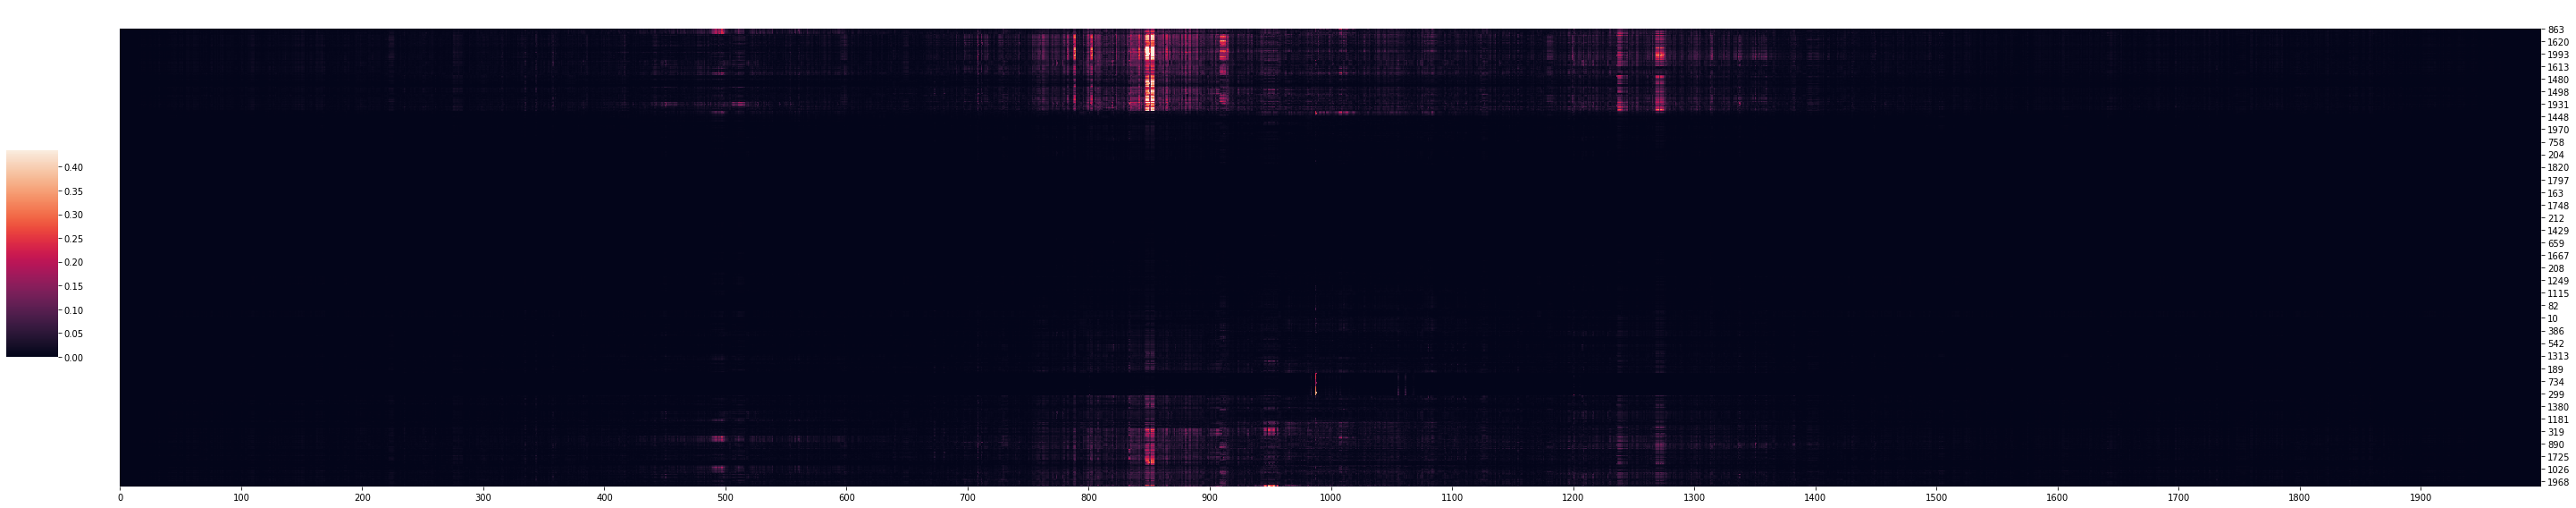

In [48]:
# heatmap of tasks (clustered) x position

cg = sns.clustermap(mut_minus_ref_euclidean[SEQ_IDX].T, 
                    row_cluster=True, # cluster tasks
                    col_cluster=False, # not position 
                    # standard_scale=0,
                    dendrogram_ratio=0.04,
                    figsize=(40,8),
                    xticklabels=100,
                    vmax = np.quantile(mut_minus_ref_euclidean[SEQ_IDX], 0.9999), # set max limit
                    cbar_pos=(0, .3, .02, .4))
cg.ax_row_dendrogram.set_visible(False)

Positions in the input have different importance scores depending on the task.

In [34]:
# sample with highest prediction
TASK_IDX = np.argsort(ref[SEQ_IDX][0][:,0])[::-1][0]

# or pick another task
# TASK_IDX = 1777 

TASK_IDX

1777

In [35]:
# output of that task
ref[SEQ_IDX, 0, TASK_IDX, 0]

0.98828876

In [36]:
# output description
outputs.iloc[TASK_IDX]

Unnamed: 0                     1778
Cell type           Small_Intestine
Assay                     DNase.hot
Treatment                       NaN
Assay type                    DNase
Source          Roadmap Epigenomics
Unnamed: 6    E109-DNase.hot.bed.gz
Name: 1777, dtype: object

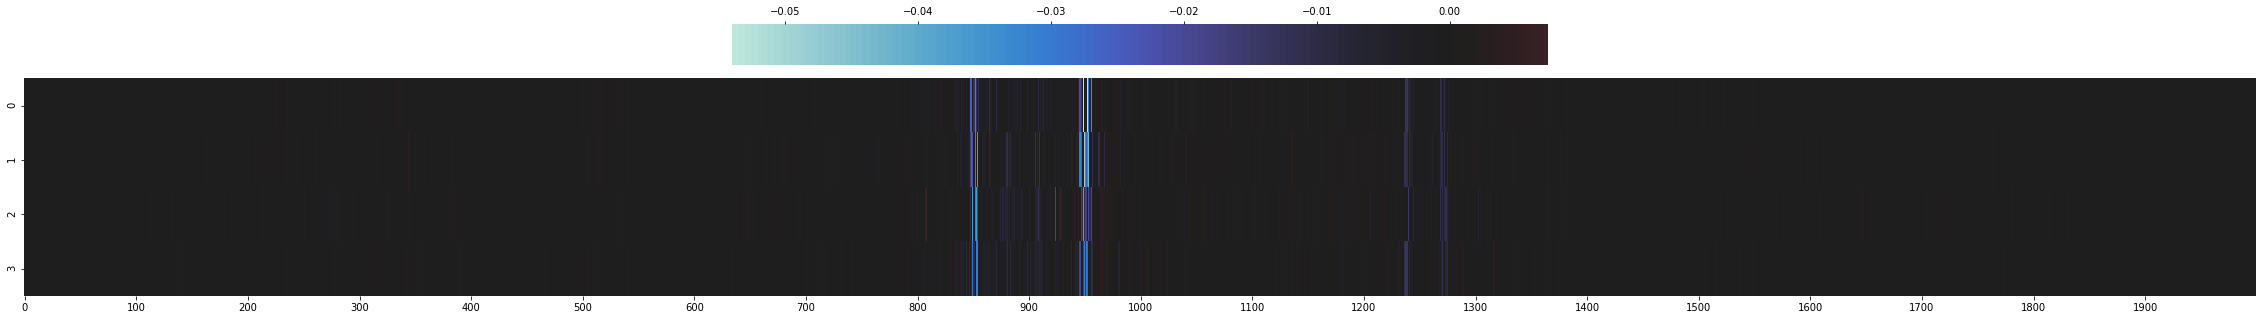

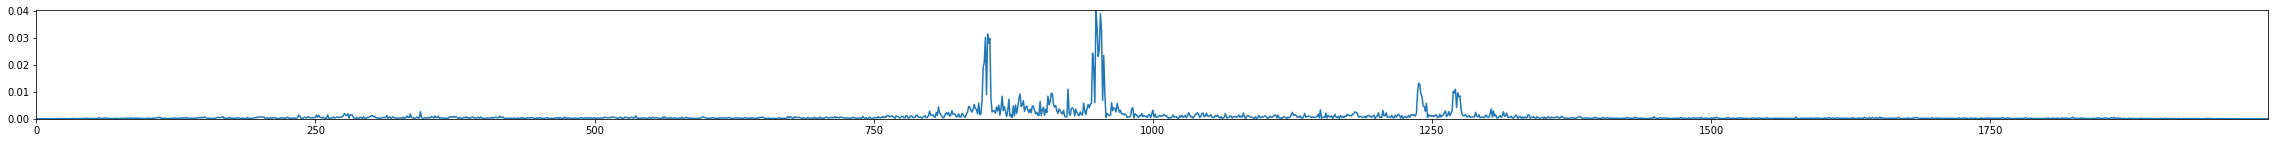

In [43]:
# heatmap of base x position
plt.figure(figsize=(40,5))
to_plot = mut_minus_ref[SEQ_IDX, :, TASK_IDX].T
sns.heatmap(to_plot, 
            center=0,
            vmin = np.quantile(to_plot, 0.0001),
            vmax = np.quantile(to_plot, 0.9999),
            xticklabels = 100,
            cbar_kws = dict(use_gridspec=False,location="top"))
plt.show()

plt.figure(figsize=(40,2))
plt.plot(mut_minus_ref_euclidean[SEQ_IDX, :, TASK_IDX])
plt.margins(0, 0)
plt.show()

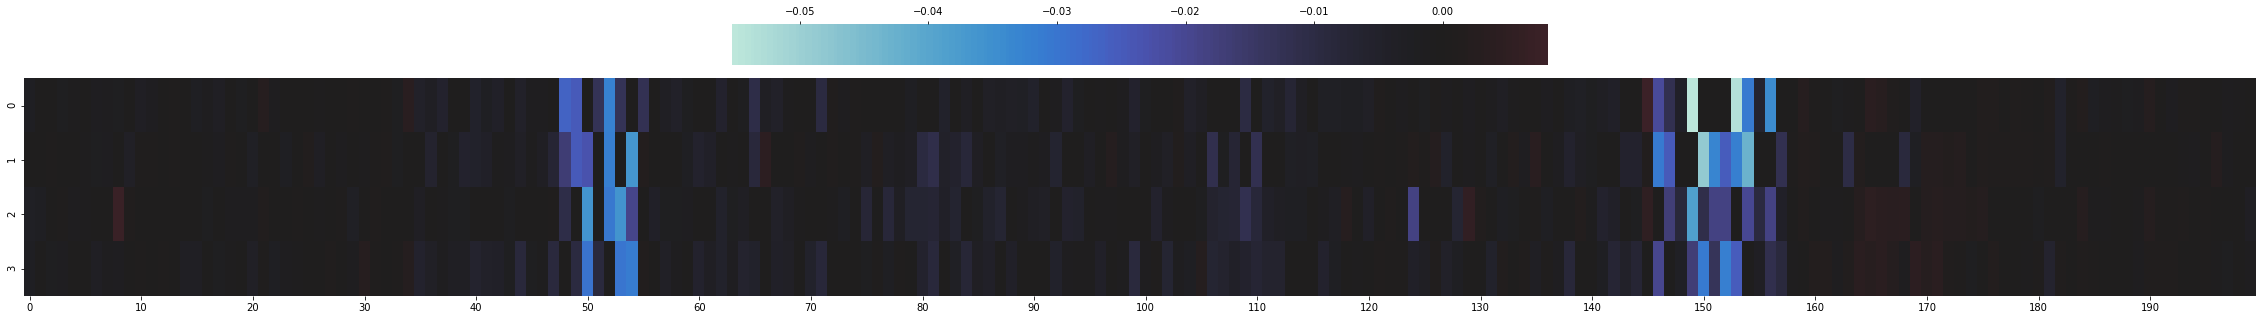

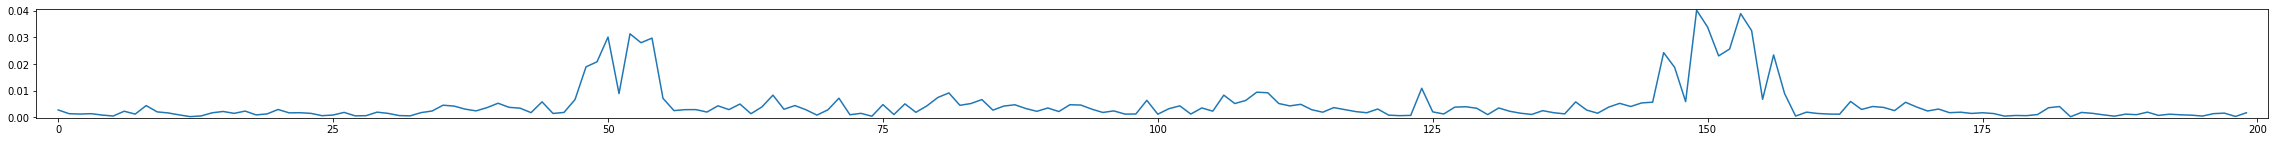

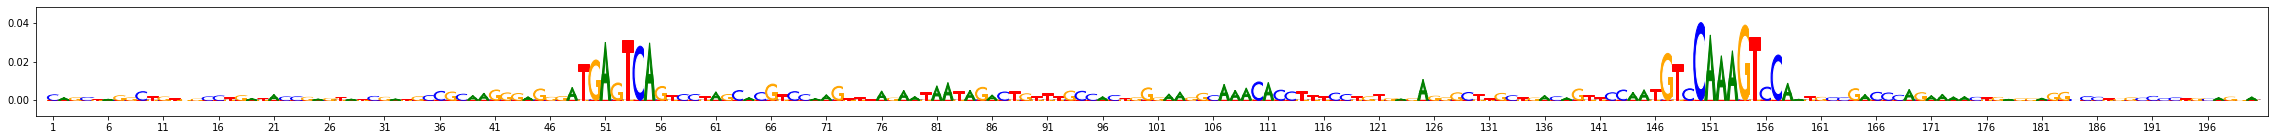

In [54]:
# Zoom in heatmap of base x position
ZOOM_IN = range(800, 1000)

plt.figure(figsize=(40,5))
to_plot = mut_minus_ref[SEQ_IDX, ZOOM_IN, TASK_IDX].T
sns.heatmap(to_plot, 
            center=0,
            vmin = np.quantile(to_plot, 0.0001),
            vmax = np.quantile(to_plot, 0.9999),
            xticklabels = 10,
            cbar_kws = dict(use_gridspec=False,location="top"))
plt.show()

plt.figure(figsize=(40,2))
plt.plot(mut_minus_ref_euclidean[SEQ_IDX, ZOOM_IN, TASK_IDX])
plt.margins(0.01, 0.01)
plt.show()

vizsequence.plot_weights(
      np.expand_dims(mut_minus_ref_euclidean[SEQ_IDX, ZOOM_IN, TASK_IDX], -1)*onehot_sequences[SEQ_IDX, ZOOM_IN],
      figsize=(40,2))

On the left is an [AP1](http://homer.ucsd.edu/homer/motif/HomerMotifDB/homerResults/motif1.info.html) motif and on the right is [HNF4](http://homer.ucsd.edu/homer/motif/HomerMotifDB/homerResults/motif159.info.html) motif.